# QuTiP Sandbox
_Will Kaufman, October 2020_

Just playing around!

Docs [here](http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html).

In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

## Kets and expectation values

In [6]:
spin = basis(2, 0)
spin

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]

In [3]:
basis(4, 0)

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

In [4]:
tensor(basis(2, 0), basis(2, 0))

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

In [7]:
expect(sigmaz(), spin)

1.0

In [4]:
expect(sigmax(), spin)

0.0

In [9]:
expect(sigmax(), ket2dm(spin))

0.0

## Spin System

In [10]:
N = 4

In [11]:
I_x = sum([
    tensor(  # I_x^i
        [identity(2)]*i
        + [sigmax()]
        + [identity(2)]*(N-i-1)
    )
    for i in range(N)
])

I_y = sum([
    tensor(  # I_x^i
        [identity(2)]*i
        + [sigmay()]
        + [identity(2)]*(N-i-1)
    )
    for i in range(N)
])

I_z = sum([
    tensor(  # I_x^i
        [identity(2)]*i
        + [sigmaz()]
        + [identity(2)]*(N-i-1)
    )
    for i in range(N)
])

In [12]:
chemical_shift = np.random.normal(scale=1e2, size=(N,))
dipolar_couplings = np.triu(np.random.normal(scale=1e0, size=(N, N)))

In [13]:
H_cs = sum([
    tensor([identity(2)]*i
           + [chemical_shift[i] * sigmaz()]
           + [identity(2)]*(N-i-1))
    for i in range(N)
])

In [14]:
H_dip = sum([
    dipolar_couplings[i, j]
    * (2 * tensor(  # I_z^i I_z^j
        [identity(2)]*i
        + [sigmaz()]
        + [identity(2)]*(j-i-1)
        + [sigmaz()]
        + [identity(2)]*(N-j-1)
    )
    - tensor(  # I_x^i I_x^j
        [identity(2)]*i
        + [sigmax()]
        + [identity(2)]*(j-i-1)
        + [sigmax()]
        + [identity(2)]*(N-j-1)
    )
    - tensor(  # I_y^i I_y^j
        [identity(2)]*i
        + [sigmay()]
        + [identity(2)]*(j-i-1)
        + [sigmay()]
        + [identity(2)]*(N-j-1)
    ))
    for i in range(N) for j in range(i+1, N)
])

In [15]:
H_cx = I_x

In [16]:
H_cy = I_y

In [17]:
def H_cy_coeff(t, args):
    nutation_frequency = 1e3
    p1 = (t > 0) & (t < np.pi/(4 * nutation_frequency))
    p2 = (t > 3e-2) & (t < 3e-2 + np.pi/(2 * nutation_frequency))
    return nutation_frequency * (p1 + p2)

In [35]:
rho0 = tensor([thermal_dm(2, 0)]*4)

In [36]:
output = mesolve([H_cs, H_dip, [H_cy, H_cy_coeff]],
                 rho0=rho0, tlist=np.linspace(0, 1e-1, 100),
                 e_ops=[I_x, I_y, I_z]
                )

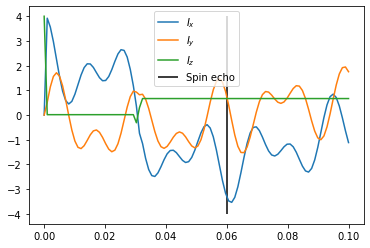

In [37]:
plt.plot(output.times, output.expect[0], label=r'$I_x$')
plt.plot(output.times, output.expect[1], label=r'$I_y$')
plt.plot(output.times, output.expect[2], label=r'$I_z$')
plt.vlines(0.06, -4, 4, color='black', label='Spin echo')
plt.legend()

## Magnus expansion

In [16]:
# not sure how to apply time-dependent unitary operator to transform frame
# maybe use mesolve and have Hamiltonian be interaction Hamiltonian, and "density matrix" be operator to transform
# TODO make sure ^ is correct

## GRAPE and CRAB

Mess around here! Could be much quicker and better...

Using [this notebook](https://github.com/qutip/qutip-notebooks/blob/master/examples/control-grape-cnot.ipynb) by Robert Johansson and [this notebook](https://github.com/qutip/qutip-notebooks/blob/master/examples/control-pulseoptim-Hadamard.ipynb) by Alexander Pitchford as inspiration.

In [66]:
from qutip.control.grape import plot_grape_control_fields, grape_unitary_adaptive, cy_grape_unitary
import qutip.control.pulseoptim as cpo

In [239]:
T = 30e-5
num_steps = 100
tau = (T / num_steps) * np.ones(num_steps)

In [240]:
U = propagator(I_x, np.pi/4)

omega_nut = 53620  # in rad/s

H_c = [
    omega_nut * I_x,
    omega_nut * I_y
]

H_labels = [
    r'$I_x$',
    r'$I_y$'
]

In [241]:
H0 = H_cs

c_ops = []

In [352]:
# TODO add robustness to control amplitude errors, etc.
# dyn_params I think is what I can use ("parameters for Dynamics object")
# or try using krotov package...

In [346]:
result = cpo.optimize_pulse_unitary(H_d=H0, H_c=H_c, U_0=tensor([identity(2)]*4),
                                    U_targ=U, num_tslots=num_steps, evo_time=T,
                                    init_pulse_type='SINE',
                                    amp_lbound=-1, amp_ubound=1)

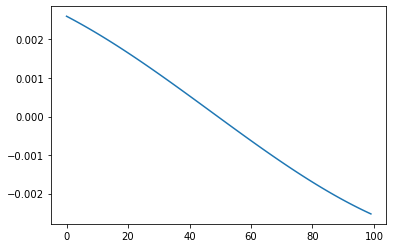

In [351]:
plt.plot(result.final_amps[:,1])

In [328]:
# seems like resulting pulse is very good
(result.evo_full_final.dag() * U).tr()

(15.997672160918722+8.984761380530747e-15j)

In [329]:
U_overall = [None]*result.final_amps.shape[0]

In [330]:
for t in range(result.final_amps.shape[0]):
    H = (H0 + H_c[0] * result.final_amps[t, 0]
         + H_c[1] * result.final_amps[t, 1])
    if t == 0:
        U_overall[0] = propagator(H, T/num_steps)
    else:
        U_overall[t] = propagator(H, T/num_steps) * U_overall[t-1]

/Users/willkaufman/anaconda3/envs/rl_pulse/lib/python3.6/site-packages/qutip/visualization.py:323: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
/Users/willkaufman/anaconda3/envs/rl_pulse/lib/python3.6/site-packages/qutip/visualization.py:331: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(ylabels)))


(<Figure size 576x432 with 2 Axes>, <AxesSubplot:>)

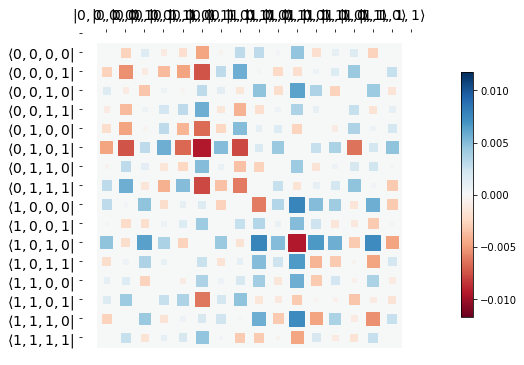

In [316]:
hinton(result.evo_full_final - U)

### Bloch sphere

In [257]:
b = Bloch()

In [331]:
b.clear()

In [332]:
states = [
    U_overall[i] * tensor([basis(2, 0)]*4) for i in range(0, 100)
]

In [333]:
pts = [expect(I_x, states)/4, expect(I_y, states)/4, expect(I_z, states)/4]

In [334]:
b.add_points(pts)

In [335]:
pts_list = [(pts[0][i], pts[1][i], pts[2][i]) for i in range(100)]

In [336]:
b.add_vectors(pts_list[-1])

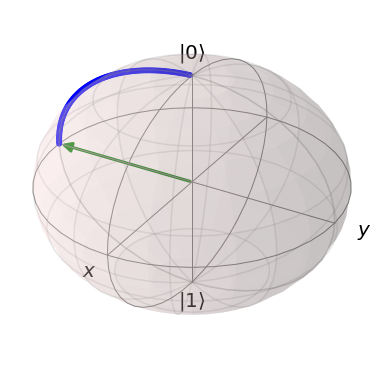

In [337]:
b.show()